In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from task_decomposition.analysis.comparisons import (get_subtask_similarity,
                                                     get_IOU,
                                                     get_semantic_distance,
                                                     extract_subtask_from_groundtruth_file,
                                                     extract_subtask_from_LLM_output_file)
from task_decomposition.utils.random_subtask_decomposition import get_random_subtask_decomposition
from task_decomposition.paths import ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH, LLM_OUTPUT_PATH
from task_decomposition.constants import (START_STEP_IDX, 
                                          END_STEP_IDX, 
                                          DESCRIPTION_IDX, 
                                          ENVIRONMENT_NAMES)

### Helper Functions

In [11]:
def _get_filepaths(env_name: str, 
                   llm_model: str, 
                   input_mode: str,  
                   kind:str, 
                   in_context: bool) -> list:
    """
    Get the list of groundtruth or LLM output filepaths for a given environment
    """
    if kind == "groundtruth":
        files_path = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)
    elif kind == "llm_output":
        files_path = LLM_OUTPUT_PATH(llm_model=llm_model, 
                                     input_mode=input_mode, 
                                     env_name=env_name,
                                     in_context=in_context)
    else:
        raise ValueError(f"Invalid kind {kind}. Must be either 'groundtruth' or 'llm_outputs'.")
    files = os.listdir(files_path)
    files.remove(".gitkeep") if ".gitkeep" in files else None
    files.remove(".DS_Store") if ".DS_Store" in files else None
    files = [os.path.join(files_path, file) for file in files]
    files = sorted(files)
    return files

### Trajectory Visualization Functions

In [33]:
def format_string(s: list) -> str:
    """
    Add a newline after every 3 words in the list
    """
    N_WORDS_PER_LINE = 2
    x = s.split(" ")
    s_format = []
    for i in range(len(x)):
        s_format.append(x[i])
        s_format.append("\n") if i % N_WORDS_PER_LINE == 0 else None
    return " ".join(s_format)

# Redefine the add_intervals_with_colors function to position the text at the edges
def add_intervals_with_colors(intervals, row, color, ax, angle):
    for idx, (start, end, description) in enumerate(intervals):
        # color = color_map[0]
        rect_width = end - start if end - start > 0 else 1
        rect = mpatches.Rectangle(
            (start, row), rect_width, 0.8, edgecolor="black", facecolor=color
        )
        ax.add_patch(rect)

        # Position the text at the top and bottom edges of the bars
        if row == 1:  # For the top bar, start the text at the top edge
            text_y = row + 0.8
            va = "bottom"
        else:  # For the bottom bar, start the text at the bottom edge
            text_y = row
            va = "top"

        # Place the text at a 45 degree angle for actual and -45 for predicted
        ax.text(
            (start+end) / 2,
            text_y,
            format_string(description),
            ha="left",
            va=va,
            fontsize="large",
            color="black",
            rotation=angle,
            rotation_mode="anchor",
        )

def plot_compare_two_trajectories(actual, 
                                  predicted, 
                                  title, 
                                  subtask_decomp_names, 
                                  ax=None):
    # Add actual intervals with color map and angle the text at 45 degrees
    add_intervals_with_colors(actual, 1, 'green', ax, angle=35)

    # Add predicted intervals with color map and angle the text at -45 degrees
    add_intervals_with_colors(predicted, 0, 'blue', ax, angle=-35)

    # Set the limits, labels, and title
    ax.set_xlim(-2, max(actual[-1][END_STEP_IDX], predicted[-1][END_STEP_IDX])+5)
    ax.set_ylim(-10, 13)
    ax.set_yticks([0.4, 1.4])
    ax.set_yticklabels([subtask_decomp_names[1], subtask_decomp_names[0]], fontsize=12)
    ax.set_xlabel("Step Number")
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

def plot_single_trajectory(subtask_decomp, title, color, ax=None):
    # Add actual intervals with color map and angle the text at 45 degrees
    add_intervals_with_colors(subtask_decomp, 1, color, ax, angle=35)

    # Set the limits, labels, and title
    ax.set_xlim(-2, subtask_decomp[-1][END_STEP_IDX]+5)
    ax.set_ylim(-7, 12)
    # ax.set_yticks([0.4, 1.4])
    # ax.set_yticklabels("Subtask Decomposition", fontsize=12)
    ax.set_xlabel("Step Number")
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

### Visualize Single Trajectory

[(0, 10, 'Move to above Cube A'), (11, 23, 'Move directly down to Cube A'), (24, 25, 'Grasp Cube A'), (26, 39, 'Vertically pick up Cube A'), (40, 48, 'Align Cube A with Cube B'), (49, 54, 'Move Cube A vertically down to Cube B'), (55, 58, 'Release Cube A onto Cube B'), (59, 62, 'Return Home')]


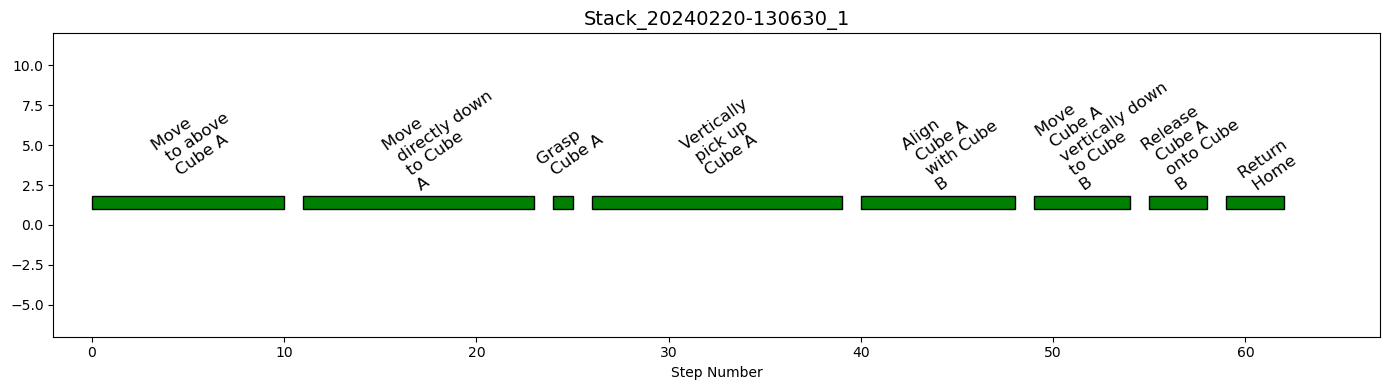

In [34]:
runid = "Stack_20240220-130630_1"
subtask_decomp = extract_subtask_from_groundtruth_file(filepath=ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH("Stack")+f"/{runid}_gt.txt")
print(subtask_decomp)
fig, ax = plt.subplots(figsize=(14, 4))
plot_single_trajectory(subtask_decomp=subtask_decomp, 
                       title=f"{runid}",
                       color="green",
                       ax=ax)

### Compare two Trajectories

Ground Truth Subtasks: [(0, 10, 'Move to above Cube A'), (11, 23, 'Move directly down to Cube A'), (24, 25, 'Grasp Cube A'), (26, 39, 'Vertically pick up Cube A'), (40, 48, 'Align Cube A with Cube B'), (49, 54, 'Move Cube A vertically down to Cube B'), (55, 58, 'Release Cube A onto Cube B'), (59, 62, 'Return Home')]
LLM Subtasks: [(0, 10, 'Move to above Cube A'), (11, 23, 'Move directly down to Cube A'), (24, 25, 'Grasp Cube A'), (26, 39, 'Vertically pick up Cube A'), (40, 54, 'Align Cube A with Cube B'), (55, 58, 'Release Cube A onto Cube B'), (59, 62, 'Return Home')]
Similarity between GT and LLM: {'temporal': 0.8775510204081632, 'semantic': 0.9836324510120209, 'total': 0.9305917357100921}


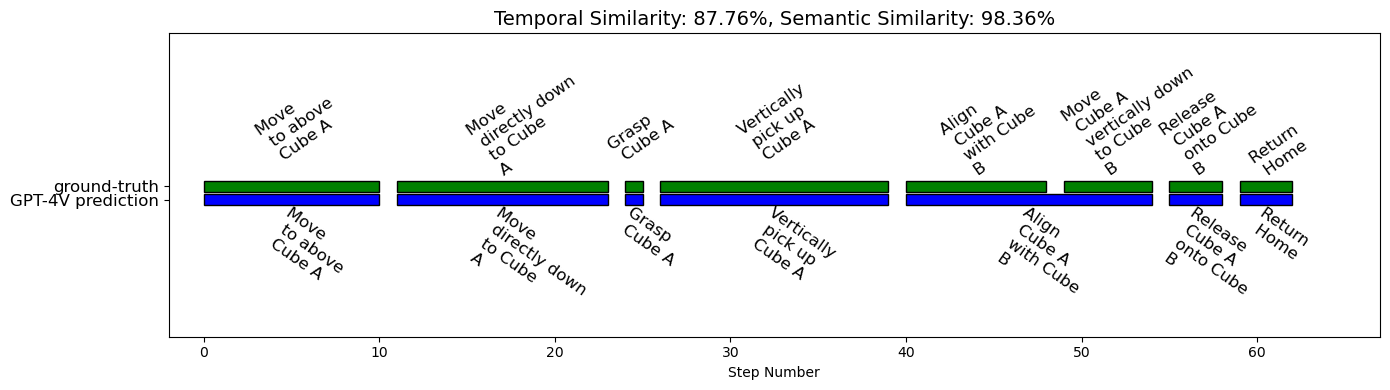

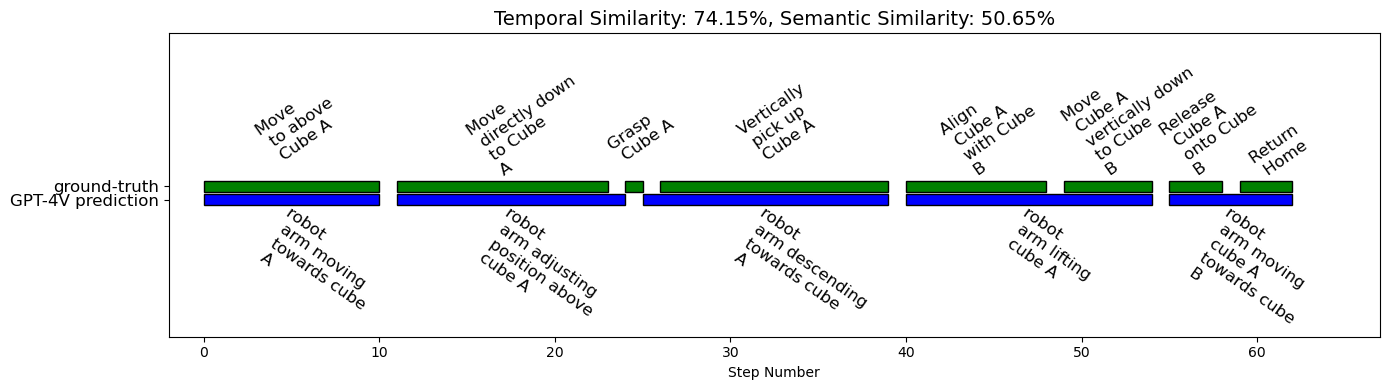

In [37]:
## visualize individual trajectory decompositions
# Example 1
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "Stack"
runid = "Stack_20240220-130630_1"
# runid = "Stack_20240220-130726_8"

# Example 2
# llm_model = "gpt-4-vision-preview"
# input_mode = "textual"
# env_name = "Lift"
# runid = "Lift_20240220-124626_1"

# Example 3
# llm_model = "video-llava"
# input_mode = "video"
# env_name = "Stack"
# runid = "Stack_20240220-131112_39"

# Example 4
# llm_model = "gemini-pro-vision"
# input_mode = "video"
# env_name = "Door"
# runid = "Door_20240213-184004_2"

## Extract the groundtruth and LLM output files
## IN CONTEXT
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
llm_file = LLM_OUTPUT_PATH(llm_model=llm_model, 
                           input_mode=input_mode, 
                           env_name=env_name, 
                           in_context=True)+f"/{runid}.json" 
gt_subtasks = extract_subtask_from_groundtruth_file(filepath=gt_file)
llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file,
                                                    llm_model=llm_model)
print(f"Ground Truth Subtasks: {gt_subtasks}")
print(f"LLM Subtasks: {llm_subtasks}")
similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
print(f"Similarity between GT and LLM: {similarity}")

fig, ax = plt.subplots(figsize=(14, 4))
title = f"Temporal Similarity: {100*similarity['temporal']:.2f}%, Semantic Similarity: {100*similarity['semantic']:.2f}%"
plot_compare_two_trajectories(actual=gt_subtasks,
                              predicted=llm_subtasks, 
                              title=title, 
                              subtask_decomp_names=["ground-truth", "GPT-4V prediction"], 
                              ax=ax)

## WITHOUT INCONTEXT
llm_file2 = LLM_OUTPUT_PATH(llm_model=llm_model, 
                           input_mode=input_mode, 
                           env_name=env_name, 
                           in_context=False)+f"/{runid}.json" 
llm_subtasks2 = extract_subtask_from_LLM_output_file(filepath=llm_file2,
                                                    llm_model=llm_model)
similarity = get_subtask_similarity(gt_subtasks, llm_subtasks2)
fig, ax = plt.subplots(figsize=(14, 4))
title = f"Temporal Similarity: {100*similarity['temporal']:.2f}%, Semantic Similarity: {100*similarity['semantic']:.2f}%"
plot_compare_two_trajectories(actual=gt_subtasks,
                              predicted=llm_subtasks2, 
                              title=title, 
                              subtask_decomp_names=["ground-truth", "GPT-4V prediction"], 
                              ax=ax)

Random Decomposition: [(0, 45, 'Set a table'), (46, 51, 'Pack objects into a box'), (52, 61, 'Open a door'), (62, 62, 'Prepare a meal')]
Similarity between GT and Random: {'temporal': 0.22783790283790284, 'semantic': 0.22053125453373743, 'total': 0.22418457868582015}


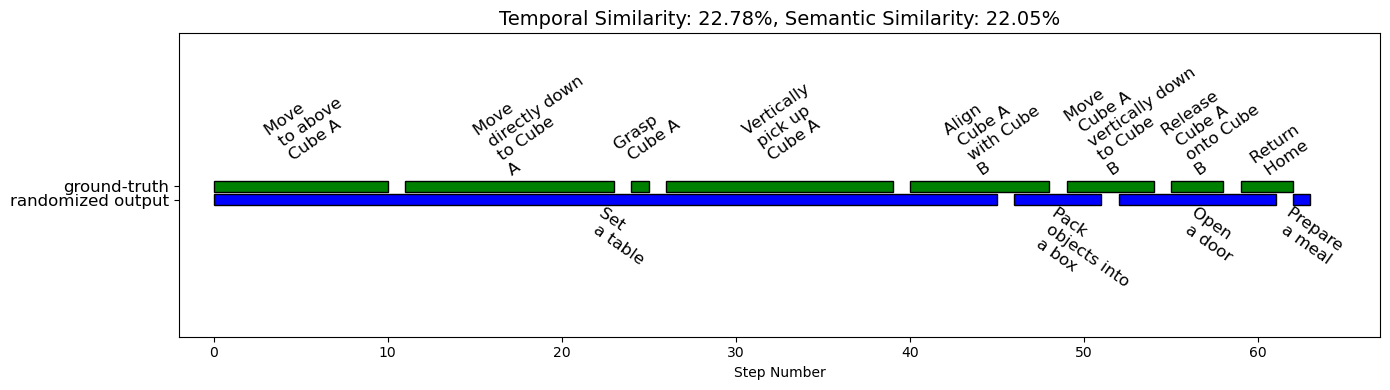

In [41]:
random_subtask_decomposition = get_random_subtask_decomposition(gt_subtasks[-1][END_STEP_IDX])
print(f"Random Decomposition: {random_subtask_decomposition}")
similarity = get_subtask_similarity(gt_subtasks, random_subtask_decomposition)
print(f"Similarity between GT and Random: {similarity}")
fig, ax = plt.subplots(figsize=(14, 4))
title = f"Temporal Similarity: {100*similarity['temporal']:.2f}%, Semantic Similarity: {100*similarity['semantic']:.2f}%"
plot_compare_two_trajectories(actual=gt_subtasks,
                              predicted=random_subtask_decomposition, 
                              title=title,
                              subtask_decomp_names=["ground-truth", "randomized output"], 
                              ax=ax)

### Compute Similarity for one Trajectory

In [ ]:
runid = "NutAssemblySquare_20240225-160809_17"
# runid = "Stack_20240220-130911_22"
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "NutAssemblySquare"
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
llm_file = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)+f"/{runid}.json"
gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file, 
                                                    llm_model=llm_model)
print(f"Ground Truth Subtasks: {gt_subtasks}")
print(f"LLM Subtasks: {llm_subtasks}")
similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
print(similarity)

### Compute Similarity Metrics in batch by ENV_NAME, INPUT_MODE, LLM_MODEL

In [172]:
def compute_batch_similarity(llm_model: str,
                            input_mode: str,
                            env_name: str,
                            in_context: bool,
                            SAVE_OUTPUT: bool = True,
                            verbose: bool = True) -> None:
    """
    Compute the similarity between groundtruth and gpt output files for a given environment.
    """
    gt_files = _get_filepaths(env_name=env_name, 
                                llm_model=llm_model, 
                                input_mode=input_mode, 
                                in_context=in_context,
                                kind="groundtruth")

    llm_files = _get_filepaths(env_name=env_name, 
                                llm_model=llm_model, 
                                input_mode=input_mode, 
                                in_context=in_context,
                                kind="llm_output")

    assert len(gt_files) == len(llm_files), f"The number of groundtruth files {len(gt_files)} and LLM output files {len(llm_files)} are not the same."

    n_runs = len(gt_files)
    output = {"temporal":np.full(n_runs, np.nan), 
              "semantic":np.full(n_runs, np.nan), 
              "total":np.full(n_runs, np.nan)}

    for idx, (gt_file, llm_file) in enumerate(zip(gt_files, llm_files)):
        # make sure we are comparing the same run
        gt_runid = gt_file.split('/')[-1].split('_gt')[0]
        llm_runid = llm_file.split('/')[-1].split('.json')[0]
        assert gt_runid==llm_runid, f"The groundtruth file {gt_file} and llm output file {llm_file} are not from the same run."

        # extract subtasks from groundtruth and gpt output files
        gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
        llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file, 
                                                            llm_model=llm_model)

        if llm_subtasks == []:    # error with processing the file
            # print(f" LLM subtask for {llm_runid} is empty")
            continue

        # compare the subtasks
        try:
            similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
        except Exception as e:
            print(f" Error with {llm_runid}: {e}")
            continue
        output['temporal'][idx]=similarity["temporal"]
        output['semantic'][idx]=similarity["semantic"]
        output['total'][idx]=similarity["total"]
        if verbose:
            print(f"{gt_runid} and {llm_runid}")
            print(f" Temporal: {similarity['temporal']:.2f} | Semantic: {similarity['semantic']:.2f}")

    # Clean the output in case nans are present
    output['temporal'] = output['temporal'][~np.isnan(output['temporal'])]
    output['semantic'] = output['semantic'][~np.isnan(output['semantic'])]
    output['total'] = output['total'][~np.isnan(output['total'])]

    if SAVE_OUTPUT:
        np.savez(f"{LLM_OUTPUT_PATH(llm_model=llm_model, input_mode=input_mode, env_name=env_name, in_context=in_context)}_results.npz", **output)

    print(f"  Number of runs: {n_runs}, Number of valid runs: {len(output['total'])}")
    print(f"  Temporal: {np.mean(output['temporal']):.2f}+/-{np.std(output['temporal']):.2f} |  Semantic: {np.mean(output['semantic']):.2f}+/-{np.std(output['semantic']):.2f}")

env_names =  ENVIRONMENT_NAMES
input_mode = "video"
llm_model = "gpt-4-vision-preview"
# llm_model = "gemini-pro-vision"
for env_name in env_names:
    print(f"input_mode: {input_mode}, llm_model: {llm_model}")
    print(f"{env_name} environment")
    for in_context in [True, False]:
        print(f" {'In' if in_context else 'Out of'} context")
        compute_batch_similarity(llm_model=llm_model,
                                input_mode=input_mode,
                                env_name=env_name,
                                in_context=in_context,
                                SAVE_OUTPUT=True,
                                verbose=False)
    print("______")


input_mode: video, llm_model: gpt-4-vision-preview
Door environment
 In context
  Number of runs: 50, Number of valid runs: 50
  Temporal: 0.70+/-0.17 |  Semantic: 0.69+/-0.18
 Out of context
  Number of runs: 50, Number of valid runs: 50
  Temporal: 0.44+/-0.10 |  Semantic: 0.53+/-0.07
______
input_mode: video, llm_model: gpt-4-vision-preview
Lift environment
 In context
  Number of runs: 50, Number of valid runs: 49
  Temporal: 0.32+/-0.14 |  Semantic: 0.48+/-0.18
 Out of context
  Number of runs: 50, Number of valid runs: 50
  Temporal: 0.32+/-0.11 |  Semantic: 0.20+/-0.04
______
input_mode: video, llm_model: gpt-4-vision-preview
PickPlace environment
 In context
  Number of runs: 50, Number of valid runs: 50
  Temporal: 0.25+/-0.07 |  Semantic: 0.37+/-0.06
 Out of context
  Number of runs: 50, Number of valid runs: 50
  Temporal: 0.25+/-0.11 |  Semantic: 0.32+/-0.07
______
input_mode: video, llm_model: gpt-4-vision-preview
Stack environment
 In context
  Number of runs: 50, Number 

### Make 2D Visualization of Similarity Metrics

gpt-4-vision-preview video DNE
gemini-pro video DNE
gemini-pro video DNE
gemini-pro textualvideo DNE
gemini-pro textualvideo DNE
video-llava textual DNE
video-llava textual DNE
video-llava textualvideo DNE
video-llava textualvideo DNE


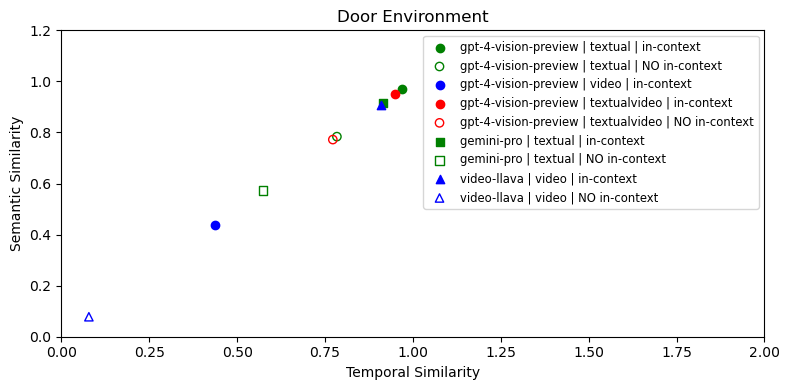

In [107]:
# create unique identifiers

input_mode_mapping = {"textual":"g", 
                      "video":"b", 
                      "textualvideo":"r"}
llm_model_mapping = {"gpt-4-vision-preview":'o', 
                     "gemini-pro":"s", 
                     "video-llava": "^"}
in_context_mapping = {True: "in-context", 
                      False: "NO in-context"}

def get_marker(llm_model: str, input_mode: str) -> str:
    return input_mode_mapping[input_mode]+llm_model_mapping[llm_model]

def plot_similarity2d(temporal_score: np.float64, 
                      semantic_score: np.float64,
                      llm_model: str,
                      ax = None) -> None:
    color = input_mode_mapping[input_mode]
    marker = llm_model_mapping[llm_model]
    ax.scatter(x=temporal_score, 
               y=semantic_score, 
               color=color, 
               marker=marker,
               facecolors='none' if not in_context else None, 
               label=f"{llm_model} | {input_mode} | {in_context_mapping[in_context]}")

env_name = ENVIRONMENT_NAMES[0]
llm_models = ["gpt-4-vision-preview", "gemini-pro", "video-llava"]
input_modes = ["textual", "video", "textualvideo"]
in_contexts = [True, False]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ax.scatter(x=0.2, y=0.2, color='k', marker='.', label="randomized baseline",linewidths=2)
for llm_model in llm_models:
    for input_mode in input_modes:
        for in_context in in_contexts:
            llm_output_data_path = LLM_OUTPUT_PATH(llm_model=llm_model, 
                                                input_mode=input_mode, 
                                                env_name=env_name, 
                                                in_context=in_context)
            if not os.path.exists(llm_output_data_path+'_results.npz'):
                print(f"{llm_model} {input_mode} DNE")
                continue

            # append to legend
            results = np.load(llm_output_data_path+'_results.npz')
            temporal_score = np.mean(results['temporal'])
            semantic_score = np.mean(results['semantic'])

            plot_similarity2d(temporal_score=temporal_score, 
                                semantic_score=temporal_score, 
                                llm_model=llm_model,
                                ax=ax)
# title_text = f"GPT-4V in {llm_model_mapping["gpt-4-vision-preview"]} and Gemini Pro in {input_mode_mapping["gemini-pro"]} | {env_name} Environment"
ax.set_xlim((0, 2))
ax.set_ylim((0, 1.2))
ax.set_xlabel("Temporal Similarity")
ax.set_ylabel("Semantic Similarity")
ax.set_title(f"{env_name} Environment")
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()

### Make histogram of similarity metrics

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonathansalfity/Documents/dev/task_decomposition/task_decomposition/data/video-llava_outputs/video/PickPlace_results.npz'

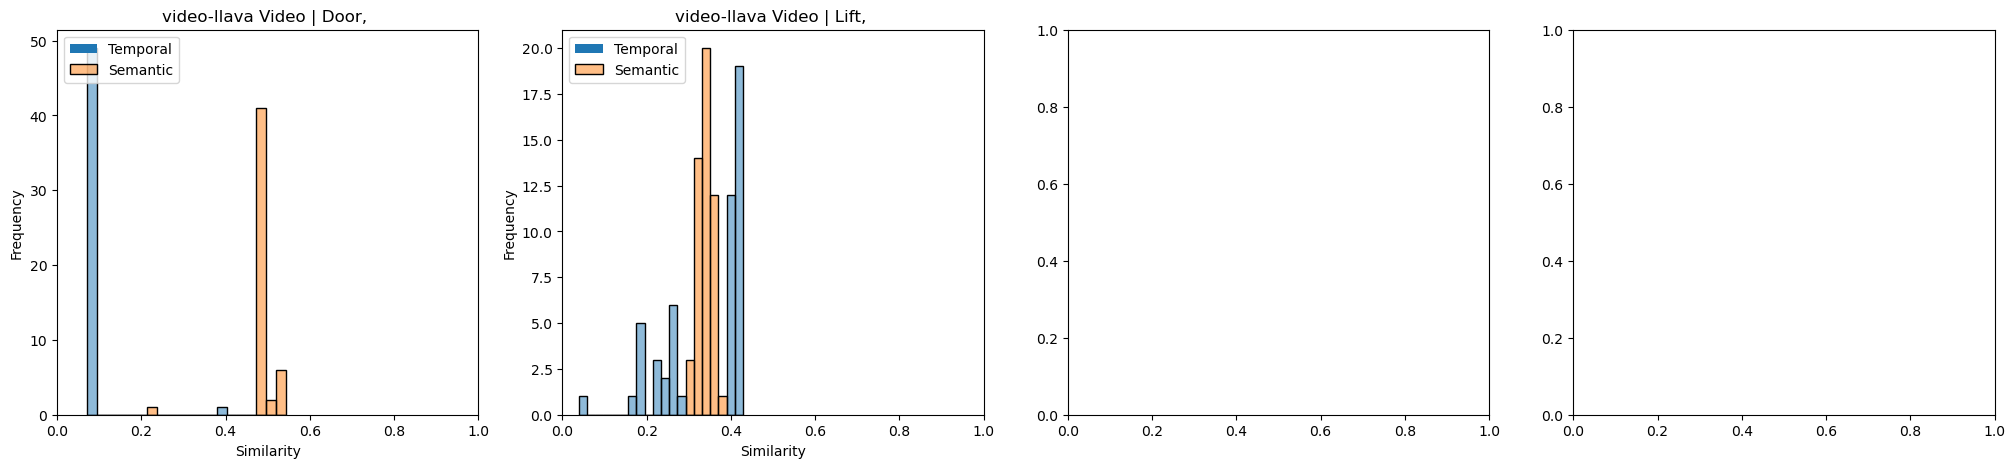

In [46]:
# sns.histplot(data=[temporal, semantic, total], legend=True, kde=True, bins=25)
# env_name = "Door"
# query_type = "video"
# npresultspath = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}" 
# similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
N_BINS = 20
def make_histogram_grid(env_names: list, input_modes: list):
    """
    Create a grid of histograms for the similarity scores between groundtruth and gpt output files.
    Each histogram will show the distribution of the similarity scores for a given environment and query type.
    """
    n_rows = len(input_modes)
    n_cols = len(env_names)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5*n_rows))
    for i, env_name in enumerate(env_names):
        for j, input_mode in enumerate(input_modes):
            npresultspath = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)
            similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
            temporal = similarity['temporal']
            semantic = similarity['semantic']
            ax = axs[j, i] if n_rows > 1 else axs[i]
            sns.histplot(data=[temporal, semantic], legend=True, bins=N_BINS, ax=ax)
            ax.legend(["Temporal", "Semantic"], loc='upper left')
            ax.set_xlabel('Similarity')
            ax.set_ylabel('Frequency')
            ax.set_xlim(0, 1)
            input_mode = "Text and Video" if input_mode=="textvideo" else input_mode.capitalize()
            ax.set_title(f"{llm_model} {input_mode} | {env_name}, ")

llm_model = "video-llava"
envs = ENVIRONMENT_NAMES
input_modes = ["video"]
make_histogram_grid(envs, input_modes)


### Make LaTex row (LLM_NAME, ENV_NAME, INPUT_MODE, SIMILARITY_METRIC, SIMILARITY_VALUE)

In [175]:
# Make the big table of all the similarity results
# llm_model = "gpt-4-vision-preview"
llm_model = "gemini-pro-vision"
# input_modes = ["textual", "textualvideo" , "video"]
input_modes = ["video"]
in_context = False
env_names =  ENVIRONMENT_NAMES
print(f"llm_model: {llm_model}, in_context: {in_context}")
print(env_names)
for input_mode in input_modes:
    print(f"{input_mode}: &", end="")
    for env_name in env_names:
        npresultspath =  LLM_OUTPUT_PATH(llm_model=llm_model, 
                                         input_mode=input_mode, 
                                         env_name=env_name,
                                         in_context=in_context)
        similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
        total_mean, total_std = np.mean(similarity['total']), np.std(similarity['total'])
        temporal_mean, temporal_std = np.mean(similarity['temporal']), np.std(similarity['temporal'])
        semantic_mean, semantic_std = np.mean(similarity['semantic']), np.std(similarity['semantic'])
        print(f'${temporal_mean:.2f} \pm {temporal_std:.2f}$ &', end="")
        print(f'${semantic_mean:.2f} \pm {semantic_std:.2f}$ &', end="")

    print('')
    print("______________________________________________________________________")

# Convert to latex:


llm_model: gemini-pro-vision, in_context: False
['Door', 'Lift', 'PickPlace', 'Stack']
video: &$0.25 \pm 0.05$ &$0.21 \pm 0.03$ &$0.17 \pm 0.04$ &$0.28 \pm 0.03$ &$0.19 \pm 0.04$ &$0.38 \pm 0.06$ &$0.31 \pm 0.04$ &$0.24 \pm 0.04$ &
______________________________________________________________________


### Compute Random Baselines for Each Environment

In [164]:
print(ENVIRONMENT_NAMES)
for env_name in ENVIRONMENT_NAMES:
    gt_files = _get_filepaths(env_name=env_name, 
                            llm_model=None, 
                            input_mode=None, 
                            kind="groundtruth")
    # print(f"Env: {env_name}")
    n_runs = len(gt_files)
    output = {"temporal": np.full(n_runs, np.nan), 
              "semantic": np.full(n_runs, np.nan), 
              "total": np.full(n_runs, np.nan)}
    for idx, gt_file in enumerate(gt_files):
        gt_subtask_decomposition = extract_subtask_from_groundtruth_file(gt_file)
        N = gt_subtask_decomposition[-1][END_STEP_IDX]
        random_subtask_decomposition = get_random_subtask_decomposition(N)
        similarity = get_subtask_similarity(gt_subtask_decomposition, 
                                            random_subtask_decomposition)
        temporal = similarity['temporal']
        semantic = similarity['semantic']
        total = similarity['total']
        output['temporal'][idx] = temporal
        output['semantic'][idx] = semantic
        output['total'][idx] = total
        # print(f" Temporal: {temporal:.2f}, Semantic: {semantic:.2f}")

    temporal_mean, temporal_std = np.mean(output['temporal']), np.std(output['temporal'])
    semantic_mean, semantic_std = np.mean(output['semantic']), np.std(output['semantic'])

    print(f'${temporal_mean:.2f} \pm {temporal_std:.2f}$ &', end="")
    print(f'${semantic_mean:.2f} \pm {semantic_std:.2f}$ &', end="")

['Door', 'Lift', 'PickPlace', 'Stack']
$0.34 \pm 0.08$ &$0.20 \pm 0.10$ &$0.41 \pm 0.10$ &$0.23 \pm 0.04$ &$0.38 \pm 0.12$ &$0.21 \pm 0.05$ &$0.33 \pm 0.07$ &$0.20 \pm 0.06$ &